# 0. Map reads onto genome sequence using Galaxy
### Unmapped BAM files are available from the Gene Expression Omnibus under accession number GSE163258. You can map them on usegalaxy.org
### Mapped BAM files are available here https://doi.org/10.6084/m9.figshare.14214131

# 1. Count reads per gene
### This uses the R script 

# 2. Calculate relative expression

### This uses a MATLAB script 

In [1]:
import numpy as np
import pandas as pd
import os
import json
import csv

# 3. Format organism metadata for PEA

In [2]:
project = 'Smutans'
os.chdir('data')

In [3]:
df = pd.read_csv(os.path.join('external','file_list_external_data.csv'))
FILE_GFF = os.path.join('external',df.at[0,'filename'])
print(FILE_GFF)
FILE_JSON = os.path.join('external',df.at[1,'filename'])
print(FILE_JSON)

external/streptococcusmutansUA159-NC_004350.gff3
external/smu00001.json


## 3.1 Create Gene Name to Locus Map from GFF

In [4]:
FILE_OUT = os.path.join('interim',project+'_Genename_to_locusID.csv')
label = 'RefSeq\tCDS'
#label = 'Genbank\tgene'
#### choose whether RefSeq or Genbank gff file source

In [5]:
entries = [] #list of dictionaries 
with open(FILE_GFF, 'r') as gff:
    for line in gff:
        line_split = line.strip().split(';')
        if label not in line_split[0]:
            continue    
        row = {}
        for item in line_split[1:]:
            key,value = item.split('=')
            row[key] = value
        entries.append(row)
        
## call up gene and locus tags
## write out gene and locus map to csv for record keeping
with open(FILE_OUT, "w") as fid:
    fid.write('name,locus_tag\n')
    for row in entries:
        fid.write(f'{row["Name"]},{row["locus_tag"]}\n')           

# mark genome size
GENOME_SIZE = len(entries)
print(GENOME_SIZE)

1958


In [6]:
# convert GFF dictionary to pandas dataframe
df_locus_IDs = pd.DataFrame.from_dict(entries)
df_locus_IDs.head()


,Parent,Dbxref,Name,Note,gbkey,gene,locus_tag,product,protein_id,transl_table
0,gene-SMU_01,"Genbank:NP_720488.1,GeneID:1029426",NP_720488.1,Best Blastp Hit: gb|AAF71535.1|AF255728_1 (AF...,CDS,dnaA,SMU_01,chromosome replication initiator DnaA,NP_720488.1,11
1,gene-SMU_02,"Genbank:NP_720489.1,GeneID:1028044",NP_720489.1,Best Blastp Hit: sp|O06672|DP3B_STRPN DNA POL...,CDS,dnaN,SMU_02,DNA polymerase III subunit beta,NP_720489.1,11
2,gene-SMU_05,"Genbank:NP_720490.1,GeneID:1029438",NP_720490.1,Best Blastp Hit: gb|AAC45338.1| (AF000658) OR...,CDS,NaN,SMU_05,hypothetical protein,NP_720490.1,11
3,gene-SMU_06,"Genbank:NP_720491.1,GeneID:1029413",NP_720491.1,Best Blastp Hit: dbj|BAB07770.1| (AP001520) G...,CDS,NaN,SMU_06,GTP-binding protein YchF,NP_720491.1,11
4,gene-SMU_07,"Genbank:NP_720492.1,GeneID:1029439",NP_720492.1,Best Blastp Hit: sp|P37470|PTH_BACSU PEPTIDYL...,CDS,pth,SMU_07,peptidyl-tRNA hydrolase,NP_720492.1,11


In [7]:
#df_locus_IDs.drop(columns=['gbkey','gene_biotype','gene'], inplace=True)

df_locus_IDs.drop(columns=['Parent','Dbxref','Note','gbkey','transl_table'], inplace=True)
df_locus_IDs.rename(columns={'locus_tag':'Locus'},inplace=True)


## 3.2 Create KEGG Pathway to gene locus map from JSON

In [8]:
FILE_OUT_PATHWAYMAP = os.path.join('interim',project+'_KEGG_Pathway_to_locusID.txt')

In [9]:
with open(FILE_JSON, 'r') as fid:
    kdf = json.load(fid)
    
with open(FILE_OUT_PATHWAYMAP, 'w') as fid:
    organism = kdf['name']
    fid.write('\t'.join(('organism','system','category','Pathway_db','Locus',
                        'gene_label')) + '\n')
    for system_dict in kdf['children']:
        system = system_dict['name']
        if 'children' not in system_dict:
            continue
        for category_dict in system_dict['children']:
            category = category_dict['name']
            if 'children' not in category_dict:
                continue
            for pathway_dict in category_dict['children']:
                pathway = pathway_dict['name']
                if 'children' not in pathway_dict:
                    continue
                for gene_dict in pathway_dict['children']:
                    gene = gene_dict['name'].split('\t')[0]
                    gene_id, gene_label = gene.split(' ', 1)
                    fid.write('\t'.join((organism, system, category, pathway, gene_id, gene_label)) + '\n')

In [10]:
# Create a pandas table to genes and lowest level pathways
kegg_df = pd.read_csv(FILE_OUT_PATHWAYMAP, sep='\t')
kegg_df.drop(columns=['organism','system','category','gene_label'], inplace = True)

In [11]:
kegg_df.head()

,Pathway_db,Locus
0,00010 Glycolysis / Gluconeogenesis [PATH:smu00...,SMU_542
1,00010 Glycolysis / Gluconeogenesis [PATH:smu00...,SMU_307
2,00010 Glycolysis / Gluconeogenesis [PATH:smu00...,SMU_1191
3,00010 Glycolysis / Gluconeogenesis [PATH:smu00...,SMU_99
4,00010 Glycolysis / Gluconeogenesis [PATH:smu00...,SMU_715


# 4. Pathway enrichment analysis

## 4.0 Merge MATLAB outputs & add gene names & locus_IDs

In [12]:
FILE_OUTPUT = os.path.join('processed', 'DifferentialExpression_Complete_List.csv')
FILE_LIST_INPUT = os.path.join('interim','file_list_relative_expression.csv')

with open(FILE_LIST_INPUT, newline='') as fid:
    reader = csv.reader(fid)
    FILE_LIST = list(reader)
    
print(FILE_LIST)

[['MUC5BMucinvsMedia', 'RelExp_MUC5BMucinvsMedia.csv'], ['MUC5BGlycanvsMedia', 'RelExp_MUC5BGlycanvsMedia.csv'], ['MUC5ACGlycanvsMedia', 'RelExp_MUC5ACGlycanvsMedia.csv']]


In [13]:
# merge MATLAB outputs and rename columns
all_df = None
for (header, fname) in FILE_LIST:
    df = pd.read_csv(os.path.join('interim',fname))
    df.rename(columns={'Gene':'Order'}, inplace=True)
    #df.set_index('Order', inplace=True)
    df.rename(columns={'p_fdr': f'{header}_pfdr'}, inplace=True)
    df.rename(columns={'log2_fold_change': f'{header}_l2fc'}, inplace=True)
    df.rename(columns={'pvals': f'{header}_pvals'}, inplace=True)
    if all_df is None:
        # First file
        all_df = df
    else:
        # Need to append
        all_df = all_df.merge(df, how='outer', on='Order')        

In [14]:
all_df

,Order,MUC5BMucinvsMedia_pvals,MUC5BMucinvsMedia_pfdr,MUC5BMucinvsMedia_l2fc,MUC5BGlycanvsMedia_pvals,MUC5BGlycanvsMedia_pfdr,MUC5BGlycanvsMedia_l2fc,MUC5ACGlycanvsMedia_pvals,MUC5ACGlycanvsMedia_pfdr,MUC5ACGlycanvsMedia_l2fc
0,NP_720488.1,1.897149e-02,5.735362e-02,-0.028402,1.489388e-21,1.117897e-20,0.139710,3.304493e-23,4.941604e-22,0.063298
1,NP_720489.1,9.720657e-03,3.983842e-02,0.000322,6.578430e-30,1.841021e-28,0.222701,4.228470e-15,1.849012e-14,0.114788
2,NP_720490.1,1.346168e-01,1.984307e-01,-0.115342,1.168172e-15,3.547983e-15,-0.157045,8.108828e-12,2.329207e-11,0.381960
3,NP_720491.1,6.225219e-02,1.192102e-01,0.062510,7.127302e-10,1.093374e-09,0.151057,2.488128e-10,5.816519e-10,-0.057223
4,NP_720492.1,1.275100e-02,4.610182e-02,0.017735,3.222733e-10,5.124460e-10,-0.029696,2.245830e-07,3.642037e-07,-0.061037
...,...,...,...,...,...,...,...,...,...,...
1954,NP_722440.1,1.647097e-01,2.281558e-01,0.121070,3.578688e-06,4.213131e-06,0.179907,1.340592e-03,1.509321e-03,-0.218726
1955,NP_722441.1,1.100338e-05,5.672530e-04,0.098640,2.749374e-14,6.949707e-14,0.099339,2.006956e-13,7.058575e-13,0.012279
1956,NP_722444.1,4.775637e-02,1.011254e-01,-0.079059,2.102374e-10,3.406576e-10,0.000032,2.880804e-16,1.517069e-15,0.327528
1957,NP_722445.1,7.632559e-03,3.461153e-02,0.055120,1.076477e-15,3.288701e-15,-0.010709,4.026172e-15,1.768447e-14,0.365763


In [15]:
all_df.at[1958,'Order'] = "NP_720543.2" #editing ComS
all_df.rename(columns={'Order':'Name'},inplace=True)
all_df.set_index('Name',inplace=True)

In [16]:
all_df

,MUC5BMucinvsMedia_pvals,MUC5BMucinvsMedia_pfdr,MUC5BMucinvsMedia_l2fc,MUC5BGlycanvsMedia_pvals,MUC5BGlycanvsMedia_pfdr,MUC5BGlycanvsMedia_l2fc,MUC5ACGlycanvsMedia_pvals,MUC5ACGlycanvsMedia_pfdr,MUC5ACGlycanvsMedia_l2fc
Name,,,,,,,,,
NP_720488.1,1.897149e-02,5.735362e-02,-0.028402,1.489388e-21,1.117897e-20,0.139710,3.304493e-23,4.941604e-22,0.063298
NP_720489.1,9.720657e-03,3.983842e-02,0.000322,6.578430e-30,1.841021e-28,0.222701,4.228470e-15,1.849012e-14,0.114788
NP_720490.1,1.346168e-01,1.984307e-01,-0.115342,1.168172e-15,3.547983e-15,-0.157045,8.108828e-12,2.329207e-11,0.381960
NP_720491.1,6.225219e-02,1.192102e-01,0.062510,7.127302e-10,1.093374e-09,0.151057,2.488128e-10,5.816519e-10,-0.057223
NP_720492.1,1.275100e-02,4.610182e-02,0.017735,3.222733e-10,5.124460e-10,-0.029696,2.245830e-07,3.642037e-07,-0.061037
...,...,...,...,...,...,...,...,...,...
NP_722440.1,1.647097e-01,2.281558e-01,0.121070,3.578688e-06,4.213131e-06,0.179907,1.340592e-03,1.509321e-03,-0.218726
NP_722441.1,1.100338e-05,5.672530e-04,0.098640,2.749374e-14,6.949707e-14,0.099339,2.006956e-13,7.058575e-13,0.012279
NP_722444.1,4.775637e-02,1.011254e-01,-0.079059,2.102374e-10,3.406576e-10,0.000032,2.880804e-16,1.517069e-15,0.327528


In [17]:
df_locus_IDs.set_index('Name',inplace=True)

In [18]:
# Add in information for comS
df_locus_IDs.at['NP_720543.2','gene'] = 'comS'
df_locus_IDs.at['NP_720543.2','Locus'] = 'SMU_62'
df_locus_IDs.at['NP_720543.2','product'] = 'comS'
df_locus_IDs.at['NP_720543.2','protein_id'] = 'NP_720543.2'

In [19]:
df_locus_IDs

,gene,Locus,product,protein_id
Name,,,,
NP_720488.1,dnaA,SMU_01,chromosome replication initiator DnaA,NP_720488.1
NP_720489.1,dnaN,SMU_02,DNA polymerase III subunit beta,NP_720489.1
NP_720490.1,NaN,SMU_05,hypothetical protein,NP_720490.1
NP_720491.1,NaN,SMU_06,GTP-binding protein YchF,NP_720491.1
NP_720492.1,pth,SMU_07,peptidyl-tRNA hydrolase,NP_720492.1
...,...,...,...,...
NP_722444.1,NaN,SMU_2161c,hypothetical protein,NP_722444.1
NP_722445.1,NaN,SMU_2162c,23S rRNA (pseudouridine(1915)-N(3))-methyltran...,NP_722445.1
NP_722446.1,htrA,SMU_2164,serine protease HtrA,NP_722446.1


In [20]:
# add gene names to dataframe
data = df_locus_IDs.join(all_df, how='outer', on='Name')
# output the differential expression with gene names & pathway maps for record keeping
data.to_csv(FILE_OUTPUT)

In [21]:
data

,gene,Locus,product,protein_id,MUC5BMucinvsMedia_pvals,MUC5BMucinvsMedia_pfdr,MUC5BMucinvsMedia_l2fc,MUC5BGlycanvsMedia_pvals,MUC5BGlycanvsMedia_pfdr,MUC5BGlycanvsMedia_l2fc,MUC5ACGlycanvsMedia_pvals,MUC5ACGlycanvsMedia_pfdr,MUC5ACGlycanvsMedia_l2fc
Name,,,,,,,,,,,,,
NP_720488.1,dnaA,SMU_01,chromosome replication initiator DnaA,NP_720488.1,1.897149e-02,5.735362e-02,-0.028402,1.489388e-21,1.117897e-20,0.139710,3.304493e-23,4.941604e-22,0.063298
NP_720489.1,dnaN,SMU_02,DNA polymerase III subunit beta,NP_720489.1,9.720657e-03,3.983842e-02,0.000322,6.578430e-30,1.841021e-28,0.222701,4.228470e-15,1.849012e-14,0.114788
NP_720490.1,NaN,SMU_05,hypothetical protein,NP_720490.1,1.346168e-01,1.984307e-01,-0.115342,1.168172e-15,3.547983e-15,-0.157045,8.108828e-12,2.329207e-11,0.381960
NP_720491.1,NaN,SMU_06,GTP-binding protein YchF,NP_720491.1,6.225219e-02,1.192102e-01,0.062510,7.127302e-10,1.093374e-09,0.151057,2.488128e-10,5.816519e-10,-0.057223
NP_720492.1,pth,SMU_07,peptidyl-tRNA hydrolase,NP_720492.1,1.275100e-02,4.610182e-02,0.017735,3.222733e-10,5.124460e-10,-0.029696,2.245830e-07,3.642037e-07,-0.061037
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP_722444.1,NaN,SMU_2161c,hypothetical protein,NP_722444.1,4.775637e-02,1.011254e-01,-0.079059,2.102374e-10,3.406576e-10,0.000032,2.880804e-16,1.517069e-15,0.327528
NP_722445.1,NaN,SMU_2162c,23S rRNA (pseudouridine(1915)-N(3))-methyltran...,NP_722445.1,7.632559e-03,3.461153e-02,0.055120,1.076477e-15,3.288701e-15,-0.010709,4.026172e-15,1.768447e-14,0.365763
NP_722446.1,htrA,SMU_2164,serine protease HtrA,NP_722446.1,8.468277e-02,1.457764e-01,-0.047197,1.911727e-12,3.884931e-12,0.140287,1.435708e-12,4.507296e-12,-0.240522


## 4.3 Select significantly up-regulated and down-regulated genes for each sample

In [22]:
FDR = 0.05 #set false discovery rate threshold

In [23]:
data.set_index('Locus', inplace=True)
#data.drop(columns=['Name','Order','protein_id'], inplace=True)
data.head(5)

,gene,product,protein_id,MUC5BMucinvsMedia_pvals,MUC5BMucinvsMedia_pfdr,MUC5BMucinvsMedia_l2fc,MUC5BGlycanvsMedia_pvals,MUC5BGlycanvsMedia_pfdr,MUC5BGlycanvsMedia_l2fc,MUC5ACGlycanvsMedia_pvals,MUC5ACGlycanvsMedia_pfdr,MUC5ACGlycanvsMedia_l2fc
Locus,,,,,,,,,,,,
SMU_01,dnaA,chromosome replication initiator DnaA,NP_720488.1,0.018971,0.057354,-0.028402,1.489388e-21,1.117897e-20,0.139710,3.304493e-23,4.941604e-22,0.063298
SMU_02,dnaN,DNA polymerase III subunit beta,NP_720489.1,0.009721,0.039838,0.000322,6.578430e-30,1.841021e-28,0.222701,4.228470e-15,1.849012e-14,0.114788
SMU_05,NaN,hypothetical protein,NP_720490.1,0.134617,0.198431,-0.115342,1.168172e-15,3.547983e-15,-0.157045,8.108828e-12,2.329207e-11,0.381960
SMU_06,NaN,GTP-binding protein YchF,NP_720491.1,0.062252,0.119210,0.062510,7.127302e-10,1.093374e-09,0.151057,2.488128e-10,5.816519e-10,-0.057223
SMU_07,pth,peptidyl-tRNA hydrolase,NP_720492.1,0.012751,0.046102,0.017735,3.222733e-10,5.124460e-10,-0.029696,2.245830e-07,3.642037e-07,-0.061037


In [24]:
# Check whether each gene is significantly up or down regulated

all_gene_enrichments = {}
for (header, fname) in FILE_LIST:
    file_data = pd.DataFrame(index=data.index) #data[[f'{header}_pfdr', f'{header}_l2fc']].copy()
    file_data['downregulated'] = (data[f'{header}_l2fc'] < 0) & (data[f'{header}_pfdr'] < FDR)
    file_data['upregulated'] = (data[f'{header}_l2fc'] > 0) & (data[f'{header}_pfdr'] < FDR)
    all_gene_enrichments[header] = file_data

## 4.4 Use Kegg-annotated pathways to check for significant enrichment


In [25]:
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

count = 0
all_pathway_enrichments = {}
for header, gene_enrichments in all_gene_enrichments.items():
    pathway_enrichments = {}
    
    for pathway, df in kegg_df.groupby('Pathway_db'):
        gene_list = df['Locus'].unique()
        
        # Calculate number of genes in this pathway
        num_genes_total = len(gene_list)
        if num_genes_total < 5:
            continue
        #freq_background = num_genes_total / GENOME_SIZE
        
        # Downselect gene list to only include ones observed in our data
        gene_list_obs = [g for g in gene_list if g in gene_enrichments.index]
        
        # Slice enrichment dataframe to only include these relevant genes
        relevant_gene_enrichments = gene_enrichments.loc[gene_list_obs]
        
        # Look for significant upregulation/downregulation
        pathway_enrichments[pathway] = {}
        for direction in ['upregulated', 'downregulated']:
            num_genes_sig = sum(relevant_gene_enrichments[direction])
            #freq_gene_sig = num_genes_sig / sum(gene_enrichments[direction])
            
            # Upper tail of hypergeometric distribution
            pval = hypergeom.sf(
                num_genes_sig,
                GENOME_SIZE,
                num_genes_total,
                sum(gene_enrichments[direction]),
            )
            
            pathway_enrichments[pathway][direction] = {
                'pval': pval,
                'input': num_genes_sig,
                'background': num_genes_total,
                'genome_size': GENOME_SIZE,
                'num_sig_genes': sum(gene_enrichments[direction]),
            }
    #print(pathway_enrichments[pathway])
    # Correct for FDR
    for direction in ['upregulated', 'downregulated']:
        pvals = [pathway_enrichments[pathway][direction]['pval'] \
                 for pathway in pathway_enrichments]
        _, pvals_corr, _, _ = multipletests(pvals, method='fdr_bh')
        for pathway, pval_corr in zip(pathway_enrichments, pvals_corr):
            pathway_enrichments[pathway][direction]['pval_corr'] = pval_corr
    count+=1
    all_pathway_enrichments[header] = pathway_enrichments
    #print(all_pathway_enrichments)


In [26]:
all_gene_enrichments.items()

dict_items([('MUC5BMucinvsMedia',            downregulated  upregulated
Locus                                
SMU_01             False        False
SMU_02             False         True
SMU_05             False        False
SMU_06             False        False
SMU_07             False         True
...                  ...          ...
SMU_2161c          False        False
SMU_2162c          False         True
SMU_2164           False        False
SMU_2165           False         True
SMU_62              True        False

[1959 rows x 2 columns]), ('MUC5BGlycanvsMedia',            downregulated  upregulated
Locus                                
SMU_01             False         True
SMU_02             False         True
SMU_05              True        False
SMU_06             False         True
SMU_07              True        False
...                  ...          ...
SMU_2161c          False         True
SMU_2162c           True        False
SMU_2164           False         True
SMU_

In [27]:
all_pathway_enrichments

{'MUC5BMucinvsMedia': {'00010 Glycolysis / Gluconeogenesis [PATH:smu00010]': {'upregulated': {'pval': 0.9995734638243893,
    'input': 0,
    'background': 26,
    'genome_size': 1958,
    'num_sig_genes': 502,
    'pval_corr': 0.999999999969157},
   'downregulated': {'pval': 0.635147994818933,
    'input': 0,
    'background': 26,
    'genome_size': 1958,
    'num_sig_genes': 74,
    'pval_corr': 0.7031995656923902}},
  '00020 Citrate cycle (TCA cycle) [PATH:smu00020]': {'upregulated': {'pval': 0.9487100308994818,
    'input': 0,
    'background': 10,
    'genome_size': 1958,
    'num_sig_genes': 502,
    'pval_corr': 0.999999999969157},
   'downregulated': {'pval': 0.3203446060300019,
    'input': 0,
    'background': 10,
    'genome_size': 1958,
    'num_sig_genes': 74,
    'pval_corr': 0.4655007556373465}},
  '00030 Pentose phosphate pathway [PATH:smu00030]': {'upregulated': {'pval': 0.6294753582596592,
    'input': 2,
    'background': 12,
    'genome_size': 1958,
    'num_sig_gen

In [28]:
FILE_PEA_OUTPUT = os.path.join('processed','PathwayEnrichmentAnalysis_Results.csv')
for header, pathway_enrichments in all_pathway_enrichments.items():
    with open(f'{FILE_PEA_OUTPUT}_{header}.txt', 'w') as fid:
        fid.write('Pathway\t')
        for direction in ['upregulated','downregulated']:
            fid.write('\t'.join(['background', f'{direction}_input', f'{direction}_FDR','FDR<0.05','']))
        fid.write('\n')
        for pathway in pathway_enrichments.keys():
            row = f'{pathway}'
            for direction in ['upregulated','downregulated']:
                row += f'\t{pathway_enrichments[pathway][direction]["background"]}'
                row += f'\t{pathway_enrichments[pathway][direction]["input"]}'
                row += f'\t{pathway_enrichments[pathway][direction]["pval_corr"]}'
                if pathway_enrichments[pathway][direction]["pval_corr"] < FDR:
                    row += '\t*'
                else:
                    row +="\t"
                
            row += '\n'
            fid.write(row)


## 4.5 Comparing overall gene expression profiles of samples


In [29]:
# calculate the Pearson's correlation coefficient
correlations = data.corr('pearson')

In [30]:
correlations

,MUC5BMucinvsMedia_pvals,MUC5BMucinvsMedia_pfdr,MUC5BMucinvsMedia_l2fc,MUC5BGlycanvsMedia_pvals,MUC5BGlycanvsMedia_pfdr,MUC5BGlycanvsMedia_l2fc,MUC5ACGlycanvsMedia_pvals,MUC5ACGlycanvsMedia_pfdr,MUC5ACGlycanvsMedia_l2fc
MUC5BMucinvsMedia_pvals,1.000000,0.995844,-0.464771,0.235182,0.235853,-0.240240,0.271547,0.274124,-0.260506
MUC5BMucinvsMedia_pfdr,0.995844,1.000000,-0.476979,0.233196,0.233890,-0.238233,0.269325,0.271876,-0.259967
MUC5BMucinvsMedia_l2fc,-0.464771,-0.476979,1.000000,-0.276101,-0.277508,0.687874,-0.269280,-0.271006,0.685571
MUC5BGlycanvsMedia_pvals,0.235182,0.233196,-0.276101,1.000000,0.999973,-0.242909,0.614216,0.615125,-0.257885
MUC5BGlycanvsMedia_pfdr,0.235853,0.233890,-0.277508,0.999973,1.000000,-0.244134,0.615833,0.616760,-0.259050
MUC5BGlycanvsMedia_l2fc,-0.240240,-0.238233,0.687874,-0.242909,-0.244134,1.000000,-0.265982,-0.267576,0.927777
MUC5ACGlycanvsMedia_pvals,0.271547,0.269325,-0.269280,0.614216,0.615833,-0.265982,1.000000,0.999954,-0.302609
MUC5ACGlycanvsMedia_pfdr,0.274124,0.271876,-0.271006,0.615125,0.616760,-0.267576,0.999954,1.000000,-0.304618
MUC5ACGlycanvsMedia_l2fc,-0.260506,-0.259967,0.685571,-0.257885,-0.259050,0.927777,-0.302609,-0.304618,1.000000


Text(0.5, 0, 'log2(Fold Change MUC5B Glycans vs CMedia)')

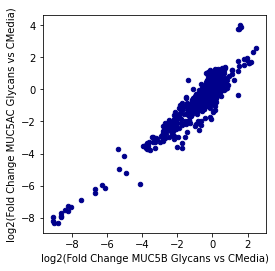

In [31]:
plot = data.plot.scatter(y='MUC5ACGlycanvsMedia_l2fc', x='MUC5BGlycanvsMedia_l2fc', c='DarkBlue', figsize=(4,4))
plot.set_ylabel('log2(Fold Change MUC5AC Glycans vs CMedia)')
plot.set_xlabel('log2(Fold Change MUC5B Glycans vs CMedia)')



Text(0.5, 0, 'log2(Fold Change MUC5B Glycans vs CMedia)')

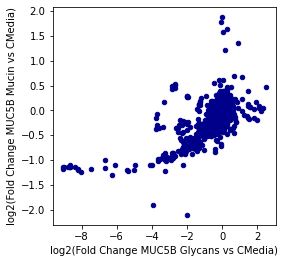

In [32]:
plot = data.plot.scatter(y='MUC5BMucinvsMedia_l2fc', x='MUC5BGlycanvsMedia_l2fc', c='DarkBlue', figsize=(4,4))
plot.set_ylabel('log2(Fold Change MUC5B Mucin vs CMedia)')
plot.set_xlabel('log2(Fold Change MUC5B Glycans vs CMedia)')

Text(0.5, 0, 'log2(Fold Change MUC5AC Glycans vs CMedia)')

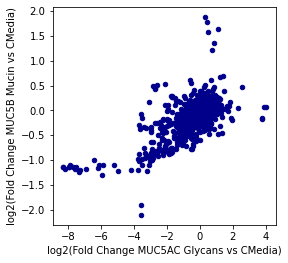

In [33]:
plot = data.plot.scatter(y='MUC5BMucinvsMedia_l2fc', x='MUC5ACGlycanvsMedia_l2fc', c='DarkBlue', figsize=(4,4))
plot.set_ylabel('log2(Fold Change MUC5B Mucin vs CMedia)')
plot.set_xlabel('log2(Fold Change MUC5AC Glycans vs CMedia)')